In [126]:
## Print multiple output per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [127]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [128]:
## Pandas Display options
pd.set_option('display.max_columns',0)
pd.set_option('display.max_colwidth',0)

# Read data

In [129]:
## Reading relevant data
match_lvl_data = pd.read_csv('data/match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('data/batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('data/bowler_level_scorecard.csv')
train_data = pd.read_csv('data/train_data_with_samplefeatures.csv')
# test_data = pd.read_csv('data/test_data_with_samplefeatures.csv')
test_data = pd.read_csv('data/r2.csv')

# Printing shape and sample rows of each dataset

In [130]:
match_lvl_data.shape
match_lvl_data.head(2)

(1689, 30)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,umpire1,umpire2,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id
0,8638034,Nn Ds,Wn,Wn,wickets,9.0,Wn,field,By Ol,Mount Maunganui,2021-01-01,night match,Sr Sh,2020/21,17681,Dn Mw,TJ Pe,148,6,130,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0:3834305.0:3776849.0:6718340.0:3566240.0:4950364.0:7543647.0,18570,2653993.0:6718326.0:6718382.0:2486896.0:2288789.0:4950224.0:8187878.0:3083667.0:4950294.0:6718396.0:1585464.0,other_domestic,18570,NaN
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7.0,Sy Tr,field,Ca Ol,Carrara,2021-01-01,night match,Bg Bh Le,2020/21,6663,D Tr,PJ Ge,166,6,106,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1594319.0:7534687.0:7537067.0:1905847.0:8339701.0:7620346.0,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652.0:5788320.0:1612610.0:5509524.0:5497274.0:3876613.0:8193310.0,other_domestic,33963,1749075.0


In [131]:
batsman_lvl_data.shape
batsman_lvl_data.head(2)

(24483, 21)

,match id,batsman,batsman_id,batsman_details,is_batsman_captain,is_batsman_keeper,inning,runs,balls_faced,over_faced_first,wicket kind,out_by_bowler,out_by_fielder,bowler_id,bowler_details,is_bowler_keeper,is_bowler_captain,strike_rate,Fours,Sixes,match_dt
0,8638034,KD Ce,7907451.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,7,5,1.1,caught,JS Nm,TM Jn,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,140.0,1.0,NaN,2021-01-01
1,8638034,TL St,4381761.0,NZ:Right-hand bat:None:,0.0,1.0,1,46,46,1.2,caught,R Ra,MG Bl,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,0.0,0.0,100.0,4.0,1.0,2021-01-01


In [132]:
bowler_lvl_data.shape
bowler_lvl_data.head(2)

(18539, 18)

,match id,bowler,bowler_id,bowler_details,is_bowler_captain,is_bowler_keeper,inning,runs,wicket_count,balls_bowled,economy,maiden,dots,Fours,Sixes,wides,noballs,match_dt
0,8638034,BV Ss,6718396.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,21,0,12,10.5,0,3.0,1,1,3,1,2021-01-01
1,8638034,HK Bt,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,1,34,1,24,8.5,0,7.0,3,1,2,0,2021-01-01


In [133]:
train_data.shape
train_data.head(2)

(948, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000


In [134]:
test_data.shape
test_data.head(2)

(207, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333


In [135]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

# Code to plot RnP

In [136]:
from matplotlib import pyplot as plt
plt.style.use('seaborn');
import re

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();

/var/folders/y9/_3j91y_j5_sb6xs2vpf3h9840000gn/T/ipykernel_59469/1758012790.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn');


# Helper function

In [137]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.
    
    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}
    
    Output-None
    
    Returns- dataframe having bowling/batting stats from last n games of a player before an input date. 
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'
        
    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False)#.head(n)


In [138]:
def calculate_weighted_sum(df, feature, halflife = 90):
    """
    Calculate the weighted sum of quantities based on exponential decay.

    Parameters:
    df (pd.DataFrame): DataFrame with 'quantity' and 'date' columns.
    a (float): Exponential decay rate parameter. Default is 0.01.

    Returns:
    float: The weighted sum of quantities.
    """
    # Calculate the decay rate parameter 'a' based on the halflife
    a = np.log(2) / halflife
    
    # Convert the 'date' column to datetime format
    df['match_dt'] = pd.to_datetime(df['match_dt'])

    # Calculate the number of days since the reference date (max date in this case)
    reference_date = df['match_dt'].max()
    df['days_since_reference'] = (reference_date - df['match_dt']).dt.days

    # Calculate the weights using the exponential decay function e^(-at)
    df['weight'] = np.exp(-a * df['days_since_reference'])

    # Calculate the weighted quantities
    df['weighted_quantity'] = df[feature] * df['weight']

    # Calculate the weighted sum
    weighted_sum = np.nansum(df['weighted_quantity'])

    return weighted_sum

# Feature creation

#### 1. team_count_runs_last15 <br>
combined feature of no of 100,50,30

In [139]:
def runs_Lastn(player_list, date, n, run):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''
    # decay_factor = 0.95
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    # milestone_score = 0
    run_u = float('inf')
    if run == 30:
        run_u = 50
    if run == 50:
        run_u = 100

    for player in player_list: # loop over each player_id in roster
        milestone_score = 0
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        # df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        # df_rel['gte_100runs'] = np.where(df_rel['runs']>=100, 1, 0) 
        df_rel['runs'] = pd.to_numeric(df_rel['runs'], errors='coerce')
        df_rel['gte_runs'] = np.where((df_rel['runs']>=run) & (df_rel['runs']<run_u), 1, 0) 
        df_rel['match_dt'] = pd.to_datetime(df_rel['match_dt'])
        # df_rel = df_rel.set_index('match_dt')
        # df_rel = df_rel.sort_index()

        # if not df_rel.empty:
        #     a = df_rel['gte_runs'][::-1]
        #     milestone_score = a.ewm(span = n, adjust = True).sum().iloc[-1]
        # milestone_score = df_rel['gte_runs'].ewm(halflife=pd.Timedelta('182.5D')).sum().iloc[-1]
        milestone_score = calculate_weighted_sum(df_rel[['match_dt', 'gte_runs']], 'gte_runs')

        # for i, row in df_rel.iterrows():
        #     if row['runs'] >= run and row['runs'] < run_u:
        #         milestone_score += 100 * (decay_factor ** i)
            
        # final = 0.30* np.nansum(df_rel['gte_100runs']) + 0.40*np.nansum(df_rel['gte_50runs']) + 0.30*np.nansum(df_rel['gte_30runs'])
        res_list.append(milestone_score)

    return np.nansum(res_list)


In [140]:
# Computing number of 50 runs in last 10 games for team1 for train dataset.
train_data['team1_50_last20'] = train_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20, run=50), axis=1)
# Computing number of 50 runs in last 10 games for team2 for train dataset.
train_data['team2_50_last20'] = train_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20, run=50), axis=1)


# Computing number of 100 runs in last 10 games for team1 for train dataset.
train_data['team1_100_last20'] = train_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20, run=100), axis=1)
# Computing number of 100 runs in last 10 games for team2 for train dataset.
train_data['team2_100_last20'] = train_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20, run=100), axis=1)

# Computing number of 30 runs in last 10 games for team1 for train dataset.
train_data['team1_30_last20'] = train_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20, run=30), axis=1)
# Computing number of 30 runs in last 10 games for team2 for train dataset.
train_data['team2_30_last20'] = train_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20, run=30), axis=1)

100%|██████████| 948/948 [00:23<00:00, 39.70it/s]


In [141]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_50_last20'] = (train_data['team1_50_last20'] +0.1)/(train_data['team2_50_last20']+ 0.1)
train_data.drop(columns=['team1_50_last20','team2_50_last20'], inplace=True) # dropping intermediate columns

# Taking ratio of (number of 100 runs in last 15 games for team1) to (number of 100 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_100_last20'] = (train_data['team1_100_last20'] +0.1)/(train_data['team2_100_last20']+ 0.1)
train_data.drop(columns=['team1_100_last20','team2_100_last20'], inplace=True) # dropping intermediate columns

# Taking ratio of (number of 30 runs in last 15 games for team1) to (number of 30 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_30_last20'] = (train_data['team1_30_last20'] +0.1)/(train_data['team2_30_last20']+ 0.1)
train_data.drop(columns=['team1_30_last20','team2_30_last20'], inplace=True) # dropping intermediate columns


In [142]:
train_data.shape
train_data.tail(2)

(948, 27)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_50_last20,team_100_last20,team_30_last20
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.931072,0.208609,0.644042
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,5.540733,11.427098,0.786688


slope: 0.51 / 0.42 =  1.21


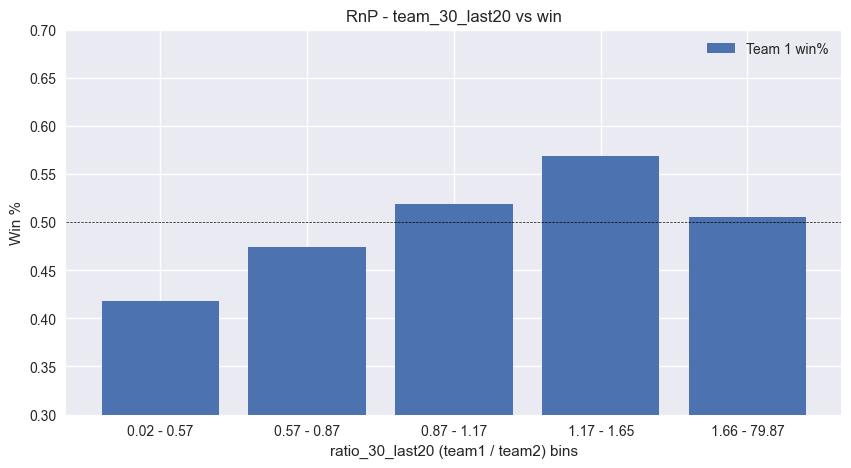

In [143]:
# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_30_last20')

slope: 0.58 / 0.43 =  1.35


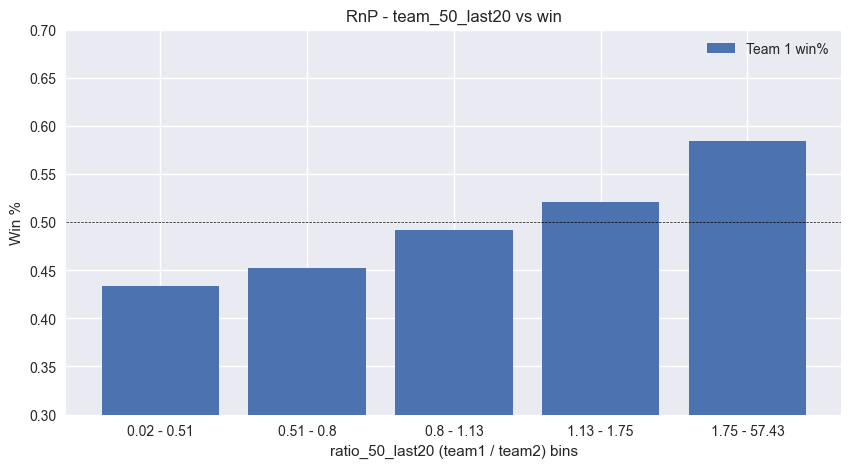

In [144]:
createRnP(train_data, 'team_50_last20')

slope: 0.53 / 0.5 =  1.05


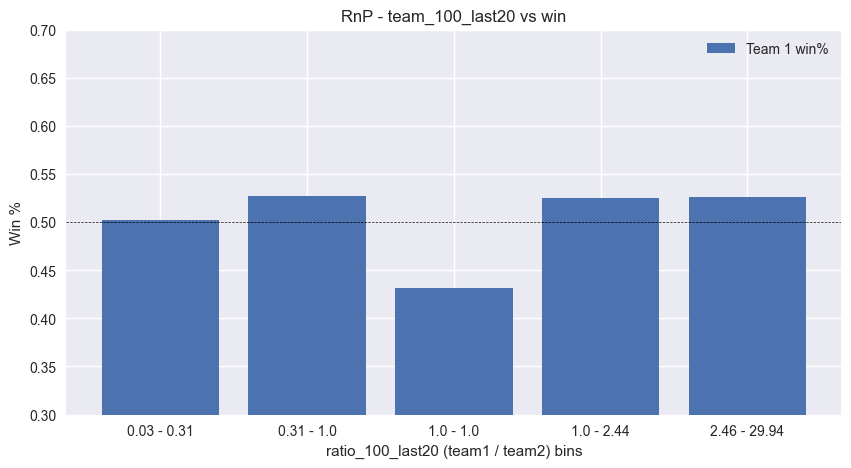

In [145]:
createRnP(train_data, 'team_100_last20')

In [146]:
# train_data['team_run_last20'] = 0.15*train_data['team_100_last20'] + 0.45*train_data['team_50_last20'] + 0.40*train_data['team_30_last20']

In [147]:
# createRnP(train_data, 'team_run_last20')

In [148]:
train_data.tail()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_50_last20,team_100_last20,team_30_last20
943,9128601,Pb Ks,30407,2789079.0:197658.0:2398346.0:2827327.0:2082044.0:5053082.0:2035102.0:3851518.0:7453697.0:7881845.0:3068547.0,Ci Sr Ks,30414,7422673.0:249087.0:3519011.0:5001170.0:232000.0:1642738.0:196580.0:2294823.0:360086.0:7879829.0:7968225.0,Pb Ks,30407,Ci Sr Ks,field,We Sm Mi,Mumbai,2022-04-25,night match,In Pr Le,2022,5004,0.823529,1.000000,147.333333,66.67,166.400000,0,0.716993,0.994078,0.834298
944,9433241,Mx,8700,4421689.0:7752989.0:1941743.0:4489722.0:7672874.0:4005406.0:7671166.0:4489708.0:8820538.0:2593758.0:3590362.0,St,9701,6139370.0:7694581.0:3294444.0:3239102.0:6320362.0:2535420.0:5288226.0:3252395.0:334963.0:2850868.0:55299.0,St,9701,St,field,Te Cr As Cy Gd Tn,Taunton,2023-06-02,day/night match,Vy Bt,2023,1042,1.571429,0.012346,167.400000,0.00,170.466667,1,1.174605,0.499061,0.972037
945,9097227,Bd,22497,4239773.0:1941743.0:3007969.0:4172972.0:1556253.0:3845029.0:2625895.0:3062555.0:4175772.0:6639156.0:4874092.0,Wn Pe,23869,323049.0:4876122.0:4164978.0:1837205.0:3373138.0:2204950.0:1858961.0:6640164.0:2659502.0:4159658.0:4239493.0,Wn Pe,23869,Bd,bat,St Gs Pk Pt Eh,Port Elizabeth,2022-02-07,day match,CA T0 Ce,2021/22,1224,3.000000,1.000000,NaN,0.00,NaN,1,15.588444,1.000000,0.745531
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.931072,0.208609,0.644042
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,5.540733,11.427098,0.786688


In [149]:
## Doing similar process for test dataset

# Computing number of 50 runs in last 15 games for team1 for train dataset.
test_data['team1_50_last20'] = test_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20, run=50), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
test_data['team2_50_last20'] = test_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20, run=50), axis=1)


# Computing number of 100 runs in last 15 games for team1 for train dataset.
test_data['team1_100_last20'] = test_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20, run=100), axis=1)
# Computing number of 100 runs in last 15 games for team2 for train dataset.
test_data['team2_100_last20'] = test_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20, run=100), axis=1)

# Computing number of 30 runs in last 15 games for team1 for train dataset.
test_data['team1_30_last20'] = test_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20, run=30), axis=1)
# Computing number of 30 runs in last 15 games for team2 for train dataset.
test_data['team2_30_last20'] = test_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20, run=30), axis=1)

# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
test_data['team_50_last20'] = (test_data['team1_50_last20']+0.1)/(test_data['team2_50_last20']+ 0.1)
test_data.drop(columns=['team1_50_last20','team2_50_last20'], inplace=True) # dropping intermediate columns

# Taking ratio of (number of 100 runs in last 15 games for team1) to (number of 100 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
test_data['team_100_last20'] = (test_data['team1_100_last20']+0.1)/(test_data['team2_100_last20']+ 0.1)
test_data.drop(columns=['team1_100_last20','team2_100_last20'], inplace=True) # dropping intermediate columns

# Taking ratio of (number of 30 runs in last 15 games for team1) to (number of 30 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
test_data['team_30_last20'] = (test_data['team1_30_last20']+0.1)/(test_data['team2_30_last20']+ 0.1)
test_data.drop(columns=['team1_30_last20','team2_30_last20'], inplace=True) # dropping intermediate columns


100%|██████████| 207/207 [00:05<00:00, 38.61it/s]


#### 2. Winning consistency <br>

In [150]:
def consistencyLastn(team_id, date, n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False)#.head(n) 
    
    df_rel['winner_01'] = df_rel.apply(lambda x: 1 if (team_id==x['winner_id']) else 0, axis=1)

    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    # p, last = None, None
    if win_count == 0:
        p = 0
        # last = 0
    else:
        p = round(win_count*100/df_rel.shape[0], 3)
        # last = 1 if df_rel['winner_id'][0]==team_id else 0
        # last = 1 if df_rel['winner_id'].iloc[0] == team_id else 0
        # last = 0


    
    # last = 1 if df_rel['winner_id'].iloc[0] == team_id else 0
    if not df_rel.empty:
        # rev = df_rel['winner_01'][::-1]
        # winp = rev.ewm(span=n, adjust=False).mean().iloc[-1] * 100
        last = 100 if df_rel['winner_id'].iloc[0] == team_id else 0
    else:
        # winp = 0
        last = 0
        
    final = 0.25*last + 0.75*p
    # if win_count == 0:
    #     return 0
    # return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points
    return final


In [151]:
# Compute team1's win% in last 5 games
train_data['team1_consistency_last20'] = train_data.progress_apply(lambda x: \
                                  consistencyLastn(x['team1_id'], x['match_dt'], 10), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_consistency_last20'] = train_data.progress_apply(lambda x: \
                                  consistencyLastn(x['team2_id'], x['match_dt'], 10), axis=1)


100%|██████████| 948/948 [00:00<00:00, 1325.28it/s]


In [152]:
# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
train_data['team_consistency_last20'] = (train_data['team1_consistency_last20']+1)/(train_data['team2_consistency_last20']+1)
train_data.drop(columns=['team1_consistency_last20', 'team2_consistency_last20'], inplace=True) # drop intermediate columns


In [153]:
train_data.shape
train_data.head(2)

(948, 28)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,1,5.610882,1.000000,5.200376,0.623923
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,0,1.104417,5.329739,0.972652,0.799086


In [154]:
## Similar process for test data

test_data['team1_consistency_last20'] = test_data.progress_apply(lambda x: \
            consistencyLastn(team_id=x['team1_id'], date=x['match_dt'], n=10), axis=1)
test_data['team2_consistency_last20'] = test_data.progress_apply(lambda x: \
            consistencyLastn(team_id=x['team2_id'], date=x['match_dt'], n=10), axis=1)
test_data['team_consistency_last20'] = (test_data['team1_consistency_last20']+1)/(test_data['team2_consistency_last20']+1)
test_data.drop(columns=['team1_consistency_last20','team2_consistency_last20'], inplace=True)
test_data.shape
test_data.head(2)

100%|██████████| 207/207 [00:00<00:00, 1267.47it/s]


(207, 25)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385,0.111407,4.518559,0.433560,1.037244
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333,0.264688,1.000000,0.285992,1.008850


slope: 0.58 / 0.39 =  1.5


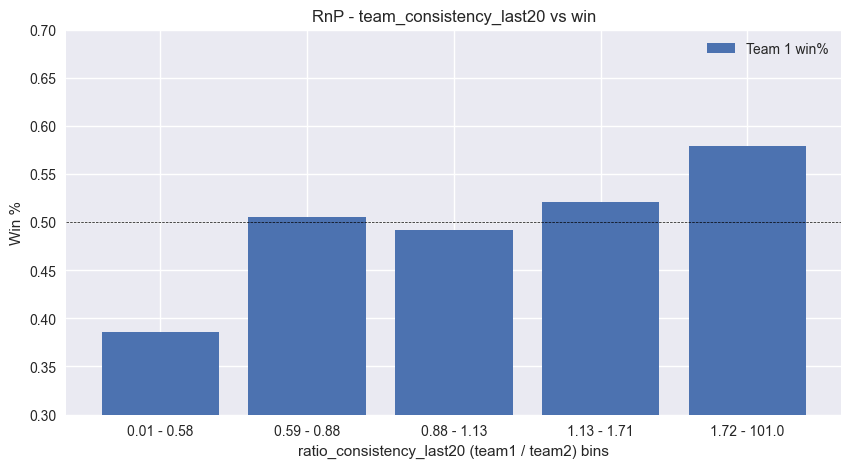

In [155]:
# RnP of team_winp_last5 computed over the train data.
createRnP(train_data, 'team_consistency_last20')#, ylim_ub=0.65)

In [156]:
# train_data.drop(columns=['winner_01'], inplace=True) # Dropping intermediate column made to plot RnP.


3. teamonly_avg_runs_last15 <br>
team1's avg inning runs in last 15 games

In [157]:
# ## derived feature computed using toss winner & toss decision to denote the inning team1 bats.
# # If team1 won the toss and chose to bat or team2 won the toss and chose to bowl, the feature takes the value 1, else 2.
# match_lvl_data['team1_bat_inning'] = np.where( ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
#                                                ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)


In [158]:
# match_lvl_data.head(2)


In [159]:
# def teamAvgRunsLastn(team_id, date, n):
#     '''
#     Function to calculate a team's average runs in their last n games.
    
#     Input-
#     1. team_id: ID of the team to calculate average runs.
#     2. date: match date of the current game for which the feature is calculated.
#     3. n: look-back window of games for the team.
    
#     Output- None
    
#     Return- Float value denoting average of runs scored by team1 in their last n games.
#     '''
#     # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
#     df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
#                       ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
#                         .sort_values(by='match_dt', ascending=False).head(n)
#     # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
#     df_rel = pd.concat([ df_rel[df_rel['team1_bat_inning']==1][['inning1_runs']].rename(columns={'inning1_runs':'runs'}), \
#                          df_rel[df_rel['team1_bat_inning']==2][['inning2_runs']].rename(columns={'inning2_runs':'runs'}) ] )
#     return df_rel['runs'].mean() # return mean of the combined dataframe.

In [160]:
# # Compute average runs scored by team1 in their last 15 games for train data.
# train_data['team1only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
#                                   teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)


In [161]:
# # Similarly for test data.
# test_data['team1only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
#             teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)
# test_data.shape
# test_data.head(2)


In [162]:
# train_data.shape
# train_data.head(2)

#### 4. teamone_winp_teamtwo_last5 <br>
  Team1's win percentage againts Team2 in last 5 games

In [163]:
def winpCrossLastn(team1_id, team2_id, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.
    
    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.
    
    Output- None
    
    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      (((match_lvl_data['team1_id']==team1_id)&(match_lvl_data['team2_id']==team2_id))|((match_lvl_data['team1_id']==team2_id)&(match_lvl_data['team2_id']==team1_id)))]\
                        .sort_values(by='match_dt', ascending=False)#.head(n)
    
    df_rel['winner_01'] = df_rel.apply(lambda x: 1 if (team1_id==x['winner_id']) else 0, axis=1)

    # if not df_rel.empty:
    #     a = df_rel['winner_01'][::-1]
    #     winp = a.ewm(span=n, adjust=False).mean().iloc[-1]
    #     return winp
    # return 0
    win_count = df_rel[df_rel['winner_id']==team1_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 3) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.
    


In [164]:
# Compute team1 win% against team2 in their past 5 encounters for train data.
train_data['team1_winp_team2'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)


100%|██████████| 948/948 [00:00<00:00, 1234.28it/s]


In [165]:
train_data.shape
train_data.head(2)

(948, 29)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,1,5.610882,1.000000,5.200376,0.623923,100.0
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,0,1.104417,5.329739,0.972652,0.799086,50.0


In [166]:
# Similarly for test data.
test_data['team1_winp_team2'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)


100%|██████████| 207/207 [00:00<00:00, 1240.81it/s]


In [167]:
test_data.shape
test_data.head(2)

(207, 26)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385,0.111407,4.518559,0.433560,1.037244,60.0
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333,0.264688,1.000000,0.285992,1.008850,0.0


slope: 0.53 / 0.45 =  1.17


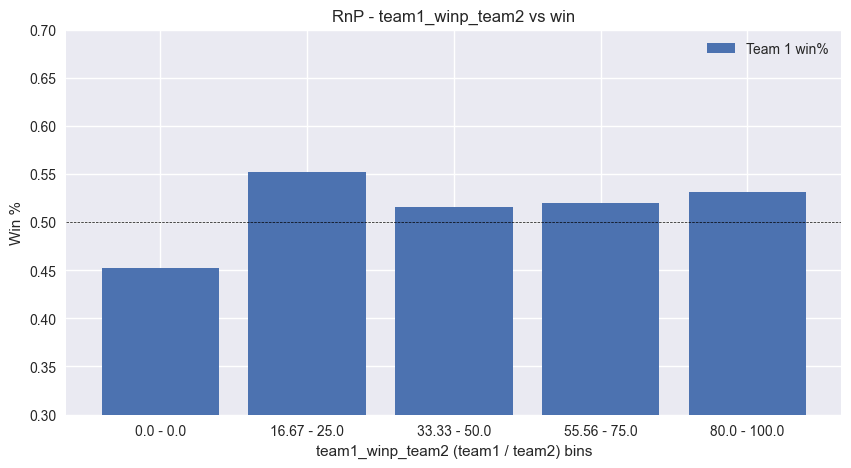

In [168]:
createRnP(train_data, 'team1_winp_team2')

5. ground_avg_runs_last15 <br>
average runs scored in the ground in last 15 games

In [169]:
# def avgRunsGround(ground_id, date, n):
#     '''
#     Function to calculate average runs scored in ground/venue.
    
#     Input-
#     1. ground_id: ID of the ground to calculate the feature for.
#     2. date: match date of the current game to calculate the feature for.
#     3. n: look-back window of games for the ground.
    
#     Output- None
    
#     Returns- Average runs scored in the ground.
#     '''
#     # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
#     df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&(match_lvl_data['ground_id']==ground_id)].sort_values(by='match_dt', ascending=False).head(n)
#     df_rel['avg_runs_inn'] = (df_rel['inning1_runs']+df_rel['inning2_runs'])/2 # take the mean of inning1_runs and inning2_runs in a separate column.
#     return df_rel['avg_runs_inn'].mean() # Return the mean value of the computed column above.


In [170]:
# ## Calculate average runs in the ground for last 15 games hosted in that venue for train data.
# train_data['ground_avg_runs_last15'] = train_data.progress_apply(lambda x: \
#                                   avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)
# ## Similarly for test data.
# test_data['ground_avg_runs_last15'] = test_data.progress_apply(lambda x: \
#                                   avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)


In [171]:
# train_data.shape
# train_data.head(2)

In [172]:
# test_data.shape
# test_data.head(2)

#### 6. Team_batting_avg_last15 <br>

In [173]:
def batavgLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- bat avg of all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    total_runs = 0
    times_dismissed = 0
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['runs'] = pd.to_numeric(df_rel['runs'], errors='coerce')
        df_rel['match_dt'] = pd.to_datetime(df_rel['match_dt'])
        # df_rel = df_rel.set_index('match_dt')
        # df_rel = df_rel.sort_index()
        df_rel['is dismissed'] = df_rel['wicket kind'].apply(lambda x: x != '')
        
        # total_runs += df_rel['runs'].ewm(halflife='6M').sum().iloc[-1]
        # times_dismissed += df_rel['wicket kind'].apply(lambda x: x != '').ewm(halflife='6M').sum().iloc[-1]
        total_runs += calculate_weighted_sum(df_rel[['match_dt', 'runs']], 'runs')
        times_dismissed += calculate_weighted_sum(df_rel[['match_dt', 'is dismissed']], 'is dismissed')

        # if times_dismissed == 0:
        #     batting_average = np.nan #float('inf')  # If never dismissed, average is infinite
        # else:
        #     batting_average = total_runs / times_dismissed
        
        # res_list.append(batting_average)

    # return np.nanmean(res_list)
    return total_runs/(times_dismissed + 0.1)


In [174]:
train_data['team1_bat_avg_last10'] = train_data.progress_apply(lambda x: \
                                  batavgLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20), axis=1)

train_data['team2_bat_avg_last10'] = train_data.progress_apply(lambda x: \
                                  batavgLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20), axis=1)


100%|██████████| 948/948 [00:32<00:00, 29.14it/s]


In [175]:
train_data['team_bat_avg_last10'] = (train_data['team1_bat_avg_last10'] +0.1)/(train_data['team2_bat_avg_last10'] +0.1)
# train_data.drop(columns=['team1_bat_avg_last10','team2_bat_avg_last10'], inplace=True) # dropping intermediate columns

slope: 0.58 / 0.48 =  1.22


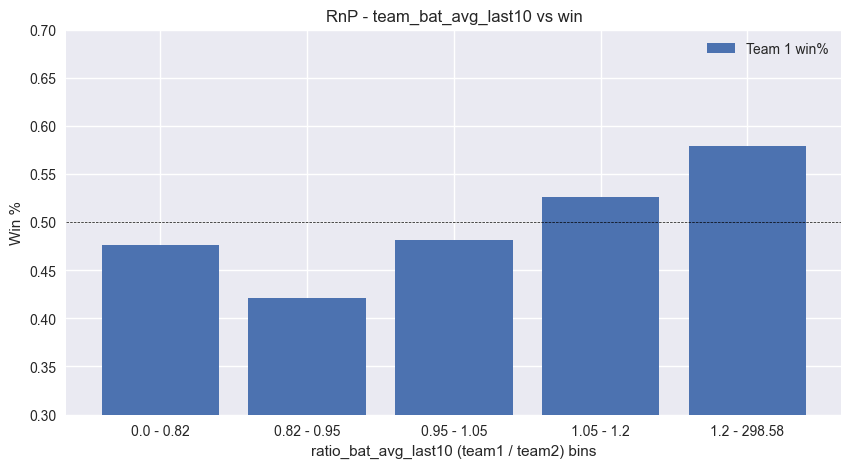

In [176]:
createRnP(train_data, 'team_bat_avg_last10')

In [177]:
test_data['team1_bat_avg_last10'] = test_data.progress_apply(lambda x: \
                                  batavgLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20), axis=1)

test_data['team2_bat_avg_last10'] = test_data.progress_apply(lambda x: \
                                  batavgLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20), axis=1)

test_data['team_bat_avg_last10'] = (test_data['team1_bat_avg_last10'] +0.1)/(test_data['team2_bat_avg_last10'] +0.1)
# test_data.drop(columns=['team1_bat_avg_last10','team2_bat_avg_last10'], inplace=True) # dropping intermediate columns

100%|██████████| 207/207 [00:07<00:00, 27.70it/s]


#### 7. Team_batting_strike_rate_last15 <br>

In [178]:
def batstrLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- bat avg of all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    # res_list = []
    total_runs = 0
    total_balls_played = 0
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['runs'] = pd.to_numeric(df_rel['runs'], errors='coerce')
        df_rel['balls_faced'] = pd.to_numeric(df_rel['balls_faced'], errors='coerce')

        df_rel['match_dt'] = pd.to_datetime(df_rel['match_dt'])
        # df_rel = df_rel.set_index('match_dt')
        # df_rel = df_rel.sort_index()
        
        # strike_rate_avg = df_rel['strike_rate'].mean()
        # total_runs += df_rel['runs'].ewm(halflife='6M').sum().iloc[-1]
        # total_balls_played += df_rel['balls_faced'].ewm(halflife='6M').sum().iloc[-1]

        total_runs += calculate_weighted_sum(df_rel[['match_dt', 'runs']], 'runs')
        total_balls_played += calculate_weighted_sum(df_rel[['match_dt', 'balls_faced']], 'balls_faced')

        # strike_rate_avg = (total_runs/total_balls_played) * 100.0
        
        # res_list.append(strike_rate_avg)

    # return np.nanmean(res_list)
    return (total_runs/(total_balls_played + 0.1)) * 100.0


In [179]:
train_data['team1_bat_strike_rate_last10'] = train_data.progress_apply(lambda x: \
                                  batstrLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20), axis=1)

train_data['team2_bat_strike_rate_last10'] = train_data.progress_apply(lambda x: \
                                  batstrLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20), axis=1)


100%|██████████| 948/948 [00:33<00:00, 28.67it/s]


In [180]:
# # Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
# train_data['team1_bat_strenght_last15'] = 0.4*train_data['team1_bat_avg_last15'] + 0.6*train_data['team1_bat_strike_rate_last15']
# train_data['team2_bat_strenght_last15'] = 0.4*train_data['team2_bat_avg_last15'] + 0.6*train_data['team2_bat_strike_rate_last15']

# train_data['team_bat_strenght_last15'] = train_data['team1_bat_strenght_last15']/ train_data['team2_bat_strenght_last15']

# # train_data.drop(columns=['team1_bat_avg_last15','team2_bat_avg_last15','team1_bat_strike_rate_last15','team2_bat_strike_rate_last15','team1_bat_strenght_last15','team2_bat_strenght_last15'], inplace=True) # dropping intermediate columns


In [181]:
train_data['team_bat_strike_rate_last10'] = (train_data['team1_bat_strike_rate_last10'] +0.1)/(train_data['team2_bat_strike_rate_last10'] +0.1)
train_data.drop(columns=['team1_bat_strike_rate_last10','team2_bat_strike_rate_last10'], inplace=True) # dropping intermediate columns

In [182]:
train_data.shape
train_data.tail(2)

(948, 33)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team1_bat_avg_last10,team2_bat_avg_last10,team_bat_avg_last10,team_bat_strike_rate_last10
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.931072,0.208609,0.644042,2.477651,66.667,25.278949,24.146035,1.046726,0.998040
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,5.540733,11.427098,0.786688,2.306556,100.000,21.415799,14.083964,1.516910,1.182496


slope: 0.59 / 0.43 =  1.38


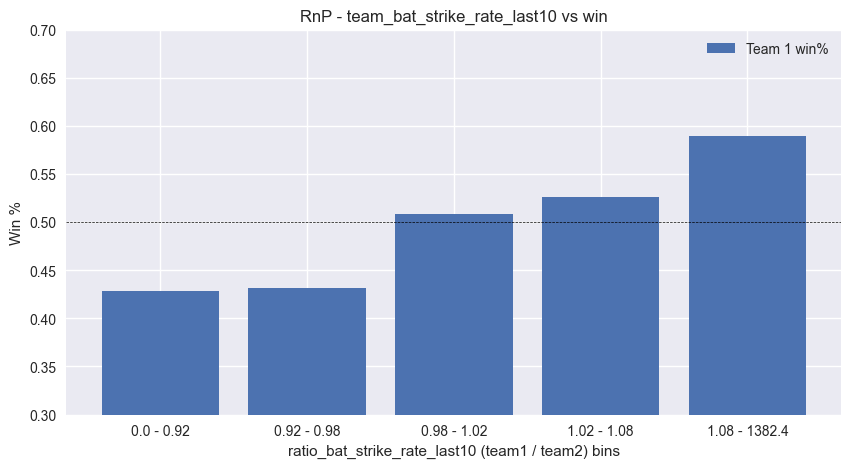

In [183]:
createRnP(train_data, 'team_bat_strike_rate_last10', N=5)

In [184]:
# test_data['team1_bat_avg_last10'] = test_data.progress_apply(lambda x: \
#                                   batavgLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=10), axis=1)

# test_data['team2_bat_avg_last10'] = test_data.progress_apply(lambda x: \
#                                   batavgLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=10), axis=1)

test_data['team1_bat_strike_rate_last10'] = test_data.progress_apply(lambda x: \
                                  batstrLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20), axis=1)

test_data['team2_bat_strike_rate_last10'] = test_data.progress_apply(lambda x: \
                                  batstrLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20), axis=1)

# Taking ratio of (number of 50 runs in last 10 games for team1) to (number of 50 runs in last 10 games for team2). Adding 1 to handle divide by zero exceptions.
# test_data['team1_bat_strenght_last10'] = 0.40*test_data['team1_bat_avg_last10'] + 0.60*test_data['team1_bat_strike_rate_last10']
# test_data['team2_bat_strenght_last10'] = 0.40*test_data['team2_bat_avg_last10'] + 0.60*test_data['team2_bat_strike_rate_last10']

# test_data['team_bat_strenght_last10'] = test_data['team1_bat_strenght_last10']/ test_data['team2_bat_strenght_last10']
test_data['team_bat_strike_rate_last10'] = (test_data['team1_bat_strike_rate_last10'] +0.1)/(test_data['team2_bat_strike_rate_last10'] +0.1)

# test_data.drop(columns=['team1_bat_avg_last10','team2_bat_avg_last10','team1_bat_strike_rate_last10','team2_bat_strike_rate_last10','team1_bat_strenght_last10','team2_bat_strenght_last10'], inplace=True) # dropping intermediate columns
test_data.drop(columns=['team1_bat_strike_rate_last10','team2_bat_strike_rate_last10'], inplace=True) # dropping intermediate columns

100%|██████████| 207/207 [00:07<00:00, 29.50it/s]


#### 8. Toss winner

In [185]:
# match_lvl_data['winner_01'] = match_lvl_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [186]:
train_data['toss_winner_01'] = train_data.apply(lambda x: 1 if (x['team1']==x['toss winner']) else 0, axis=1)

In [187]:
train_data.tail()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team1_bat_avg_last10,team2_bat_avg_last10,team_bat_avg_last10,team_bat_strike_rate_last10,toss_winner_01
943,9128601,Pb Ks,30407,2789079.0:197658.0:2398346.0:2827327.0:2082044.0:5053082.0:2035102.0:3851518.0:7453697.0:7881845.0:3068547.0,Ci Sr Ks,30414,7422673.0:249087.0:3519011.0:5001170.0:232000.0:1642738.0:196580.0:2294823.0:360086.0:7879829.0:7968225.0,Pb Ks,30407,Ci Sr Ks,field,We Sm Mi,Mumbai,2022-04-25,night match,In Pr Le,2022,5004,0.823529,1.000000,147.333333,66.67,166.400000,0,0.716993,0.994078,0.834298,0.429003,66.667,18.251240,19.423841,0.939940,1.023171,0
944,9433241,Mx,8700,4421689.0:7752989.0:1941743.0:4489722.0:7672874.0:4005406.0:7671166.0:4489708.0:8820538.0:2593758.0:3590362.0,St,9701,6139370.0:7694581.0:3294444.0:3239102.0:6320362.0:2535420.0:5288226.0:3252395.0:334963.0:2850868.0:55299.0,St,9701,St,field,Te Cr As Cy Gd Tn,Taunton,2023-06-02,day/night match,Vy Bt,2023,1042,1.571429,0.012346,167.400000,0.00,170.466667,1,1.174605,0.499061,0.972037,0.267754,0.000,17.382592,16.682644,1.041707,0.930657,0
945,9097227,Bd,22497,4239773.0:1941743.0:3007969.0:4172972.0:1556253.0:3845029.0:2625895.0:3062555.0:4175772.0:6639156.0:4874092.0,Wn Pe,23869,323049.0:4876122.0:4164978.0:1837205.0:3373138.0:2204950.0:1858961.0:6640164.0:2659502.0:4159658.0:4239493.0,Wn Pe,23869,Bd,bat,St Gs Pk Pt Eh,Port Elizabeth,2022-02-07,day match,CA T0 Ce,2021/22,1224,3.000000,1.000000,NaN,0.00,NaN,1,15.588444,1.000000,0.745531,1.000000,0.000,19.047649,12.955856,1.466595,1.060461,1
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.931072,0.208609,0.644042,2.477651,66.667,25.278949,24.146035,1.046726,0.998040,1
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,5.540733,11.427098,0.786688,2.306556,100.000,21.415799,14.083964,1.516910,1.182496,0


slope: 0.51 / 0.47 =  1.07


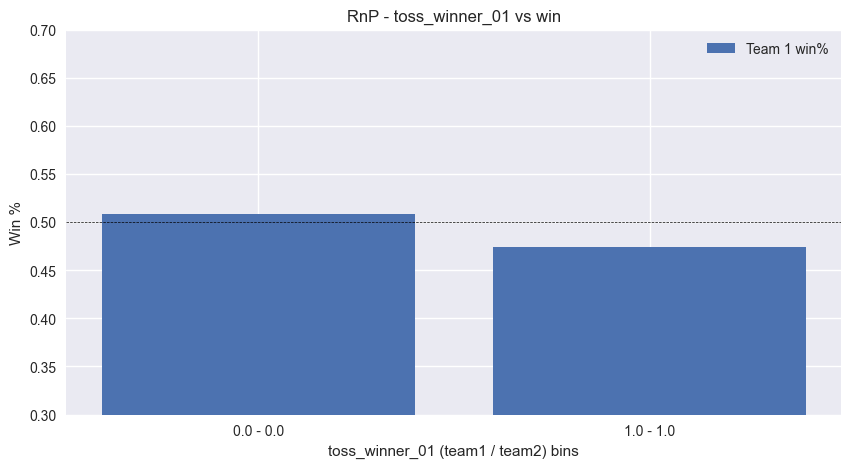

In [188]:
createRnP(train_data, 'toss_winner_01')

In [189]:
test_data['toss_winner_01'] = test_data.apply(lambda x: 1 if (x['team1']==x['toss winner']) else 0, axis=1)

#### 9. Lightning

In [190]:
train_data['light'] = train_data.apply(lambda x: 0 if (x['lighting']=='day/night match') else ( 1 if (x['lighting']=='day match') else 2), axis=1)

slope: 0.53 / 0.5 =  1.05


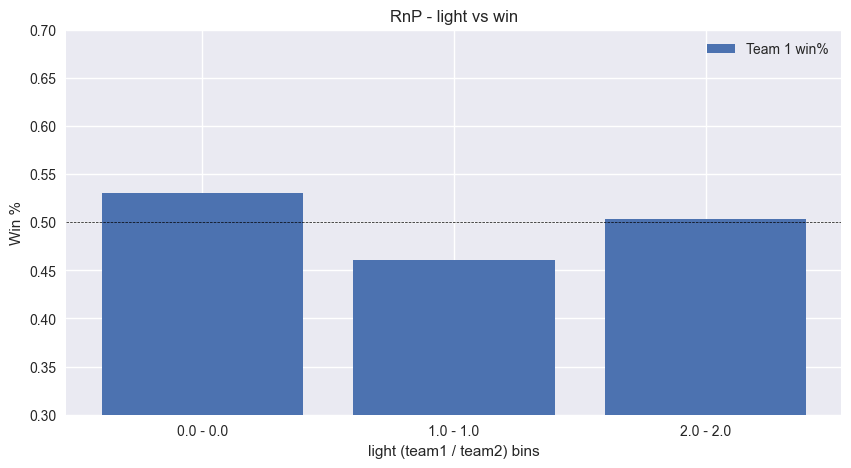

In [191]:
createRnP(train_data, 'light')

In [192]:
test_data['light'] = test_data.apply(lambda x: 0 if (x['lighting']=='day/night match') else ( 1 if (x['lighting']=='day match') else 2), axis=1)

#### 9. Team1_bowling_average_last15 <br>

In [193]:
def bowlavgLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- bat avg of all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    total_runs = 0
    total_overs = 0
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting batting stats from last n games for each player.

        df_rel['runs'] = pd.to_numeric(df_rel['runs'], errors='coerce')
        df_rel['wicket_count'] = pd.to_numeric(df_rel['wicket_count'], errors='coerce')

        df_rel['match_dt'] = pd.to_datetime(df_rel['match_dt'])
        # df_rel = df_rel.set_index('match_dt')
        # df_rel = df_rel.sort_index()

        # total_runs += df_rel['runs'].ewm(halflife='6M').sum().iloc[-1]
        # total_overs += df_rel['wicket_count'].ewm(halflife='6M').sum().iloc[-1]

        total_runs += calculate_weighted_sum(df_rel[['match_dt', 'runs']], 'runs')  
        total_overs += calculate_weighted_sum(df_rel[['match_dt', 'wicket_count']], 'wicket_count')
        # times_dismissed += df_rel['wicket kind'].apply(lambda x: x != '').sum()

        # if times_dismissed == 0:
        #     batting_average = np.nan #float('inf')  # If never dismissed, average is infinite
        # else:
        #     batting_average = total_runs / times_dismissed
        
        # res_list.append(batting_average)

    # return np.nanmean(res_list)
    return total_runs/(total_overs +0.1)


In [194]:
train_data['team1_bowl_avg_last10'] = train_data.progress_apply(lambda x: \
                                  bowlavgLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20), axis=1)

train_data['team2_bowl_avg_last10'] = train_data.progress_apply(lambda x: \
                                  bowlavgLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20), axis=1)


100%|██████████| 948/948 [00:29<00:00, 32.39it/s]


In [195]:
train_data['team_bowl_avg_last10'] = (train_data['team1_bowl_avg_last10'] +0.1)/(train_data['team2_bowl_avg_last10'] +0.1)
# train_data.drop(columns=['team1_bowl_avg_last10', 'team2_bowl_avg_last10'], inplace=True)

slope: 0.51 / 0.44 =  1.17


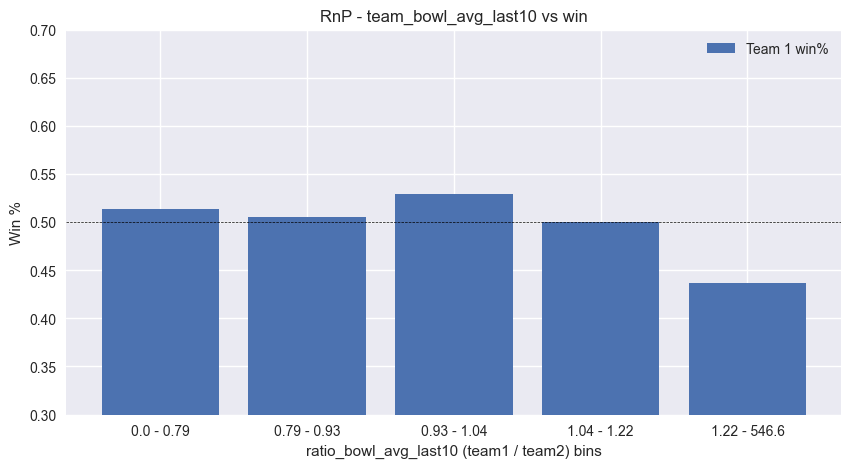

In [196]:
createRnP(train_data, 'team_bowl_avg_last10')

In [197]:
test_data['team1_bowl_avg_last10'] = test_data.progress_apply(lambda x: \
                                  bowlavgLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_bowl_avg_last10'] = test_data.progress_apply(lambda x: \
                                  bowlavgLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team_bowl_avg_last10'] = (test_data['team1_bowl_avg_last10'] +0.1)/(test_data['team2_bowl_avg_last10'] +0.1)
# test_data.drop(columns=['team1_bowl_avg_last10', 'team2_bowl_avg_last10'], inplace=True)

100%|██████████| 207/207 [00:06<00:00, 31.62it/s]


#### 10. Team_bowling_strike_rate_last15 <br>

In [198]:
def bowlstrLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- bat avg of all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    total_balls = 0
    total_wickets = 0
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting batting stats from last n games for each player.

        df_rel['balls_bowled'] = pd.to_numeric(df_rel['balls_bowled'], errors='coerce')
        df_rel['wicket_count'] = pd.to_numeric(df_rel['wicket_count'], errors='coerce')

        df_rel['match_dt'] = pd.to_datetime(df_rel['match_dt'])
        # df_rel = df_rel.set_index('match_dt')
        # df_rel = df_rel.sort_index()

        # total_balls += df_rel['balls_bowled'].ewm(halflife='6M').sum().iloc[-1]
        # total_wickets += df_rel['wicket_count'].ewm(halflife='6M').sum().iloc[-1]

        total_balls += calculate_weighted_sum(df_rel[['match_dt', 'balls_bowled']], 'balls_bowled')
        total_wickets += calculate_weighted_sum(df_rel[['match_dt', 'wicket_count']], 'wicket_count')
        
        # times_dismissed += df_rel['wicket kind'].apply(lambda x: x != '').sum()

        # if times_dismissed == 0:
        #     batting_average = np.nan #float('inf')  # If never dismissed, average is infinite
        # else:
        #     batting_average = total_runs / times_dismissed
        
        # res_list.append(batting_average)

    # return np.nanmean(res_list)
    return total_balls/(total_wickets +0.1)


In [199]:
train_data['team1_bowl_strike_rate_last10'] = train_data.progress_apply(lambda x: \
                                  bowlstrLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20), axis=1)

train_data['team2_bowl_strike_rate_last10'] = train_data.progress_apply(lambda x: \
                                  bowlstrLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20), axis=1)


100%|██████████| 948/948 [00:29<00:00, 32.36it/s]


In [200]:
# # Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
# train_data['team1_bowl_strenght_last15'] = 0.5*train_data['team1_bowl_avg_last15'] + 0.5*train_data['team1_bowl_strike_rate_last15']
# train_data['team2_bowl_strenght_last15'] = 0.5*train_data['team2_bowl_avg_last15'] + 0.5*train_data['team2_bowl_strike_rate_last15']

# train_data['team_bowl_strenght_last15'] = train_data['team1_bowl_strenght_last15']/ train_data['team2_bowl_strenght_last15']

# # train_data.drop(columns=['team1_bowl_avg_last15','team2_bowl_avg_last15','team1_bowl_strike_rate_last15','team2_bowl_strike_rate_last15','team1_bowl_strenght_last15','team2_bowl_strenght_last15'], inplace=True) # dropping intermediate columns


In [201]:
train_data['team_bowl_strike_rate_last10'] = (train_data['team1_bowl_strike_rate_last10'] +0.1)/(train_data['team2_bowl_strike_rate_last10'] +0.1)
train_data.drop(columns=['team1_bowl_strike_rate_last10', 'team2_bowl_strike_rate_last10'], inplace=True)

In [202]:
train_data.shape
train_data.tail(2)

(948, 39)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team1_bat_avg_last10,team2_bat_avg_last10,team_bat_avg_last10,team_bat_strike_rate_last10,toss_winner_01,light,team1_bowl_avg_last10,team2_bowl_avg_last10,team_bowl_avg_last10,team_bowl_strike_rate_last10
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.931072,0.208609,0.644042,2.477651,66.667,25.278949,24.146035,1.046726,0.998040,1,2,21.189846,25.605372,0.828226,0.873834
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,5.540733,11.427098,0.786688,2.306556,100.000,21.415799,14.083964,1.516910,1.182496,0,0,21.658955,24.052131,0.900912,0.949082


slope: 0.5 / 0.46 =  1.09


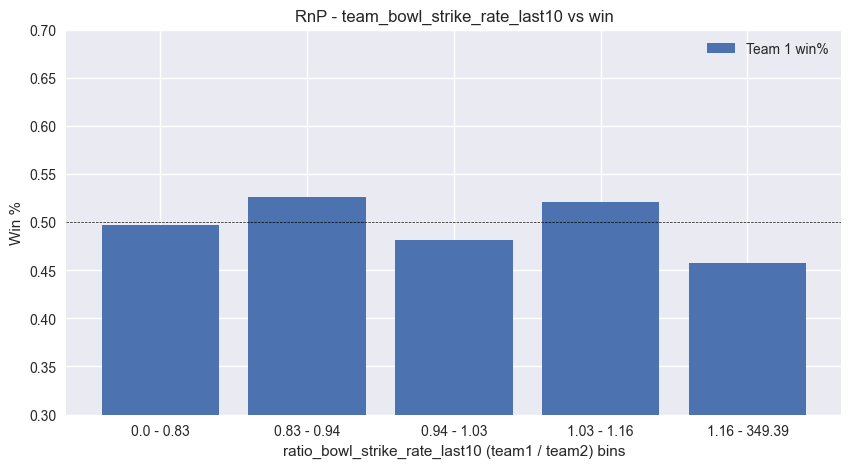

In [203]:
createRnP(train_data, 'team_bowl_strike_rate_last10')

In [204]:
# test_data['team1_bowl_avg_last10'] = test_data.progress_apply(lambda x: \
#                                   bowlavgLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=10), axis=1)

# test_data['team2_bowl_avg_last10'] = test_data.progress_apply(lambda x: \
#                                   bowlavgLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=10), axis=1)
test_data['team1_bowl_strike_rate_last10'] = test_data.progress_apply(lambda x: \
                                  bowlstrLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_bowl_strike_rate_last10'] = test_data.progress_apply(lambda x: \
                                  bowlstrLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Taking ratio of (number of 50 runs in last 10 games for team1) to (number of 50 runs in last 10 games for team2). Adding 1 to handle divide by zero exceptions.
# test_data['team1_bowl_strenght_last10'] = 0.5*test_data['team1_bowl_avg_last10'] + 0.5*test_data['team1_bowl_strike_rate_last10']
# test_data['team2_bowl_strenght_last10'] = 0.5*test_data['team2_bowl_avg_last10'] + 0.5*test_data['team2_bowl_strike_rate_last10']

# test_data['team_bowl_strenght_last10'] = test_data['team1_bowl_strenght_last10']/ test_data['team2_bowl_strenght_last10']
test_data['team_bowl_strike_rate_last10'] = (test_data['team1_bowl_strike_rate_last10'] +0.1)/(test_data['team2_bowl_strike_rate_last10'] +0.1)
test_data.drop(columns=['team1_bowl_strike_rate_last10','team2_bowl_strike_rate_last10'], inplace=True) # dropping intermediate columns


100%|██████████| 207/207 [00:06<00:00, 31.60it/s]


#### 10. Economy

In [205]:
def bowlecoLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- bat avg of all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    total_runs = 0
    total_overs = 0
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting batting stats from last n games for each player.

        df_rel['runs'] = pd.to_numeric(df_rel['runs'], errors='coerce')
        df_rel['balls_bowled'] = pd.to_numeric(df_rel['balls_bowled'], errors='coerce')

        df_rel['match_dt'] = pd.to_datetime(df_rel['match_dt'])
        # df_rel = df_rel.set_index('match_dt')
        # df_rel = df_rel.sort_index()

        # total_runs += df_rel['runs'].ewm(halflife='6M').sum().iloc[-1]
        # total_overs += (df_rel['balls_bowled']/6).ewm(halflife='6M').sum().iloc[-1]

        total_runs += calculate_weighted_sum(df_rel[['match_dt', 'runs']], 'runs')
        total_overs += calculate_weighted_sum(df_rel[['match_dt', 'balls_bowled']], 'balls_bowled')/6
        # times_dismissed += df_rel['wicket kind'].apply(lambda x: x != '').sum()

        # if times_dismissed == 0:
        #     batting_average = np.nan #float('inf')  # If never dismissed, average is infinite
        # else:
        #     batting_average = total_runs / times_dismissed
        
        # res_list.append(batting_average)

    # return np.nanmean(res_list)
    return (total_runs)/(total_overs +0.1)


In [206]:
train_data['team1_eco'] = train_data.progress_apply(lambda x: \
                                  bowlecoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=1), axis=1)

train_data['team2_eco'] = train_data.progress_apply(lambda x: \
                                  bowlecoLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=1), axis=1)

train_data['team_eco'] = (train_data['team1_eco'] +0.1)/(train_data['team2_eco'] +0.1)
train_data.drop(columns=['team1_eco','team2_eco'], inplace=True)

100%|██████████| 948/948 [00:29<00:00, 32.34it/s]


slope: 0.48 / 0.45 =  1.05


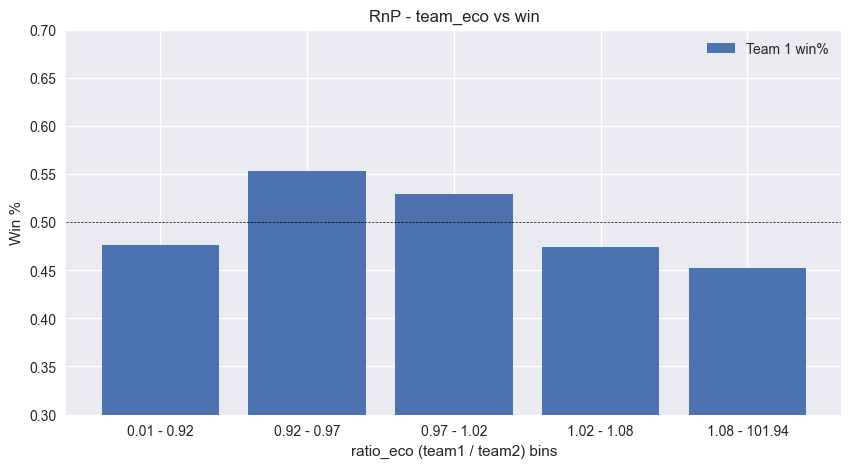

In [207]:
createRnP(train_data, 'team_eco')

In [208]:
test_data['team1_eco'] = test_data.progress_apply(lambda x: \
                                  bowlecoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=1), axis=1)

test_data['team2_eco'] = test_data.progress_apply(lambda x: \
                                  bowlecoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=1), axis=1)

test_data['team_eco'] = (test_data['team1_eco'] +0.1)/(test_data['team2_eco'] +0.1)
test_data.drop(columns=['team1_eco','team2_eco'], inplace=True)

100%|██████████| 207/207 [00:06<00:00, 31.52it/s]


#### 10. Master

In [209]:
train_data['team_bat_master'] = train_data['team1_bat_avg_last10'] * train_data['team2_bowl_avg_last10']
train_data['team_bowl_master'] = train_data['team2_bat_avg_last10'] * train_data['team1_bowl_avg_last10']
train_data.drop(columns=['team1_bat_avg_last10','team1_bowl_avg_last10', 'team2_bat_avg_last10', 'team2_bowl_avg_last10'], inplace=True) # dropping intermediate columns

In [210]:
test_data['team_bat_master'] = test_data['team1_bat_avg_last10'] * test_data['team2_bowl_avg_last10']
test_data['team_bowl_master'] = test_data['team2_bat_avg_last10'] * test_data['team1_bowl_avg_last10']
test_data.drop(columns=['team1_bat_avg_last10','team1_bowl_avg_last10', 'team2_bat_avg_last10', 'team2_bowl_avg_last10'], inplace=True) # dropping intermediate columns

slope: 0.62 / 0.38 =  1.62


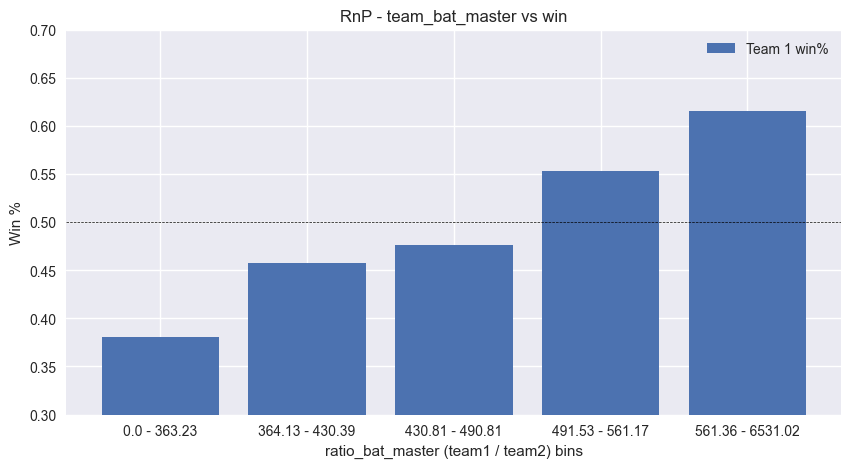

In [211]:
createRnP(train_data, 'team_bat_master')

slope: 0.49 / 0.45 =  1.09


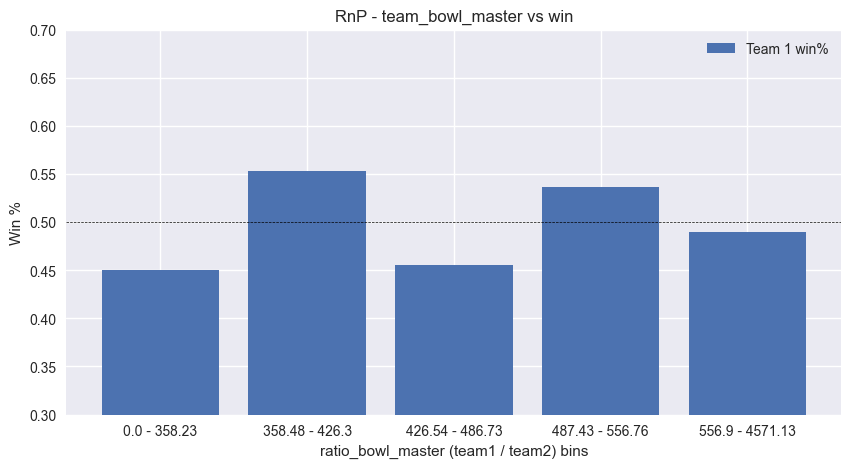

In [212]:
createRnP(train_data, 'team_bowl_master')

#### 10. wickets_taken_last15

In [213]:
def wickets_Lastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []

    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting batting stats from last n games for each player.

        df_rel['wicket_count'] = pd.to_numeric(df_rel['wicket_count'], errors='coerce')

        df_rel['match_dt'] = pd.to_datetime(df_rel['match_dt'])
        # df_rel = df_rel.set_index('match_dt')
        # df_rel = df_rel.sort_index()

        df_rel['3_wicket_haul'] = np.where(df_rel['wicket_count']>=3, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        # df_rel['gte_100runs'] = np.where(df_rel['runs']>=100, 1, 0) 
        # df_rel['gte_30runs'] = np.where(df_rel['runs']>=30, 1, 0) 
        final = 0
        # if not df_rel.empty:
        #     x = df_rel['wicket_count'][::-1]
        #     y = df_rel['3_wicket_haul'][::-1]
        
        #     wicket_count = x.ewm(span = n, adjust= True).sum().iloc[-1]
        #     a = y.ewm(span = n, adjust= True).sum().iloc[-1]
        #     final = 0.35* a + 0.65*wicket_count

        # a = df_rel['3_wicket_haul'].ewm(halflife='6M').sum().iloc[-1]
        # wicket_count = df_rel['wicket_count'].ewm(halflife='6M').sum().iloc[-1]

        a = calculate_weighted_sum(df_rel[['match_dt', '3_wicket_haul']], '3_wicket_haul')
        wicket_count = calculate_weighted_sum(df_rel[['match_dt', 'wicket_count']], 'wicket_count')

        final = 0.35* a + 0.65*wicket_count  
        res_list.append(final)

    return np.nansum(res_list)


In [214]:
# Computing number of 50 runs in last 20 games for team1 for train dataset.
train_data['team1_count_wickets_last20'] = train_data.progress_apply(lambda x: \
            wickets_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20), axis=1)
# Computing number of 50 wickets in last 20 games for team2 for train dataset.
train_data['team2_count_wickets_last20'] = train_data.progress_apply(lambda x: \
            wickets_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20), axis=1)


100%|██████████| 948/948 [00:29<00:00, 31.80it/s]


In [215]:
# Taking ratio of (number of 50 runs in last 20 games for team1) to (number of 50 runs in last 20 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_count_wickets_last20'] = (train_data['team1_count_wickets_last20']+0.1)/(train_data['team2_count_wickets_last20']+0.1)
train_data.drop(columns=['team1_count_wickets_last20','team2_count_wickets_last20'], inplace=True) # dropping intermediate columns

In [216]:
train_data.tail(2)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team_bat_avg_last10,team_bat_strike_rate_last10,toss_winner_01,light,team_bowl_avg_last10,team_bowl_strike_rate_last10,team_eco,team_bat_master,team_bowl_master,team_count_wickets_last20
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.931072,0.208609,0.644042,2.477651,66.667,1.046726,0.998040,1,2,0.828226,0.873834,0.948427,647.276896,511.650754,1.212017
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,5.540733,11.427098,0.786688,2.306556,100.000,1.516910,1.182496,0,0,0.900912,0.949082,0.950066,515.095591,305.043951,1.624720


slope: 0.61 / 0.34 =  1.8


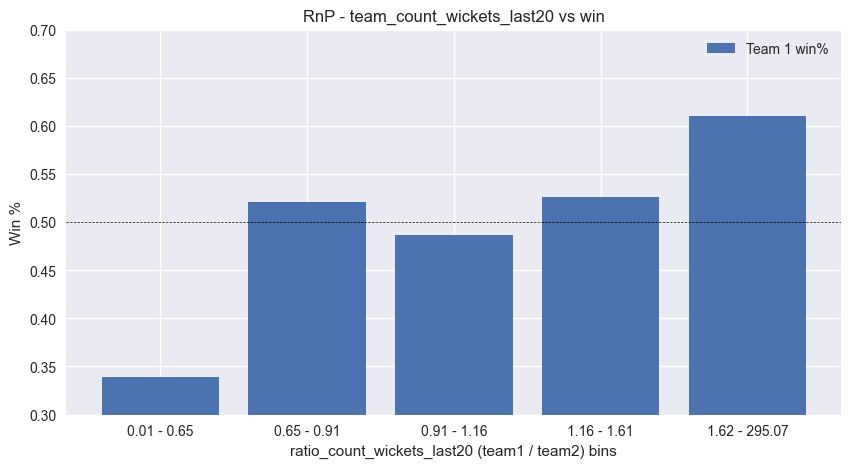

In [217]:
createRnP(train_data, 'team_count_wickets_last20')

In [218]:
# Computing number of 50 runs in last 20 games for team1 for train dataset.
test_data['team1_count_wickets_last20'] = test_data.progress_apply(lambda x: \
            wickets_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20), axis=1)
# Computing number of 50 wickets in last 20 games for team2 for train dataset.
test_data['team2_count_wickets_last20'] = test_data.progress_apply(lambda x: \
            wickets_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20), axis=1)
# Taking ratio of (number of 50 runs in last 20 games for team1) to (number of 50 runs in last 20 games for team2). Adding 1 to handle divide by zero exceptions.
test_data['team_count_wickets_last20'] = (test_data['team1_count_wickets_last20']+0.1)/(test_data['team2_count_wickets_last20']+0.1)
test_data.drop(columns=['team1_count_wickets_last20','team2_count_wickets_last20'], inplace=True) # dropping intermediate columns


100%|██████████| 207/207 [00:06<00:00, 31.16it/s]


#### 11. Discipline factor

In [219]:
def discipline_Lastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []

    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting batting stats from last n games for each player.

        df_rel['maiden'] = pd.to_numeric(df_rel['maiden'], errors='coerce')

        df_rel['match_dt'] = pd.to_datetime(df_rel['match_dt'])
        # df_rel = df_rel.set_index('match_dt')
        # df_rel = df_rel.sort_index()
        
        # df_rel['5_wicket_haul'] = np.where(df_rel['wicket_count']>=5, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        # df_rel['gte_100runs'] = np.where(df_rel['runs']>=100, 1, 0) 
        # df_rel['gte_30runs'] = np.where(df_rel['runs']>=30, 1, 0) 
        # if not df_rel.empty:
        #     a = df_rel['maiden'][::-1]
        #     b = df_rel['noballs'][::-1]
        #     c = df_rel['wides'][::-1]
        #     maiden = a.ewm(span = n, adjust= True).sum().iloc[-1]
        #     extra = b.ewm(span = n, adjust= True).sum().iloc[-1] + c.ewm(span = n, adjust= True).sum().iloc[-1]
        #     # final = -0.20* extra + 0.80*maiden
        #     final = maiden
        #     res_list.append(final)

        # maiden = df_rel['maiden'].ewm(halflife='6M').sum().iloc[-1]

        maiden = calculate_weighted_sum(df_rel[['match_dt', 'maiden']], 'maiden')
        res_list.append(maiden)

    return np.nansum(res_list)


In [220]:
# Computing number of 50 runs in last 20 games for team1 for train dataset.
train_data['team1_discipline_last20'] = train_data.progress_apply(lambda x: \
            discipline_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20), axis=1)
# Computing number of 50 wickets in last 20 games for team2 for train dataset.
train_data['team2_discipline_last20'] = train_data.progress_apply(lambda x: \
            discipline_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20), axis=1)


100%|██████████| 948/948 [00:20<00:00, 47.00it/s]


In [221]:
# Taking ratio of (number of 50 runs in last 20 games for team1) to (number of 50 runs in last 20 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_discipline_last20'] = (train_data['team1_discipline_last20']+0.1)/(train_data['team2_discipline_last20']+0.1)
train_data.drop(columns=['team1_discipline_last20','team2_discipline_last20'], inplace=True) # dropping intermediate columns

In [222]:
train_data.tail(2)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team_bat_avg_last10,team_bat_strike_rate_last10,toss_winner_01,light,team_bowl_avg_last10,team_bowl_strike_rate_last10,team_eco,team_bat_master,team_bowl_master,team_count_wickets_last20,team_discipline_last20
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.931072,0.208609,0.644042,2.477651,66.667,1.046726,0.998040,1,2,0.828226,0.873834,0.948427,647.276896,511.650754,1.212017,0.317586
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,5.540733,11.427098,0.786688,2.306556,100.000,1.516910,1.182496,0,0,0.900912,0.949082,0.950066,515.095591,305.043951,1.624720,7.386688


slope: 0.54 / 0.4 =  1.35


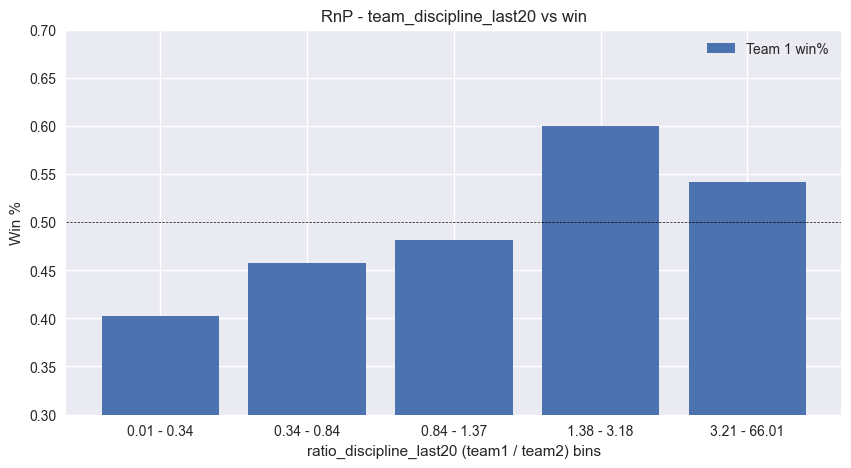

In [223]:
createRnP(train_data, 'team_discipline_last20')

In [224]:
# Computing number of 50 runs in last 20 games for team1 for train dataset.
test_data['team1_discipline_last20'] = test_data.progress_apply(lambda x: \
            wickets_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=20), axis=1)
# Computing number of 50 wickets in last 20 games for team2 for train dataset.
test_data['team2_discipline_last20'] = test_data.progress_apply(lambda x: \
            wickets_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=20), axis=1)
# Taking ratio of (number of 50 runs in last 20 games for team1) to (number of 50 runs in last 20 games for team2). Adding 1 to handle divide by zero exceptions.
test_data['team_discipline_last20'] = (test_data['team1_discipline_last20']+0.1)/(test_data['team2_discipline_last20']+0.1)
test_data.drop(columns=['team1_discipline_last20','team2_discipline_last20'], inplace=True) # dropping intermediate columns


100%|██████████| 207/207 [00:06<00:00, 31.04it/s]


#### 12. pressure index

In [225]:
match_lvl_data['series_type'].unique()

array(['other_domestic', 'international', 'In Pr Le'], dtype=object)

In [226]:
match_lvl_data['pressure_index'] = match_lvl_data.apply(lambda x: 0 if (x['series_type']=='other_domestic') else ( 1 if (x['series_type']=='In Pr Le') else 2), axis=1)

In [227]:
train_data = train_data.merge(match_lvl_data[['match id', 'pressure_index']], on='match id', how = 'left')

In [228]:
train_data.tail()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team_bat_avg_last10,team_bat_strike_rate_last10,toss_winner_01,light,team_bowl_avg_last10,team_bowl_strike_rate_last10,team_eco,team_bat_master,team_bowl_master,team_count_wickets_last20,team_discipline_last20,pressure_index
943,9128601,Pb Ks,30407,2789079.0:197658.0:2398346.0:2827327.0:2082044.0:5053082.0:2035102.0:3851518.0:7453697.0:7881845.0:3068547.0,Ci Sr Ks,30414,7422673.0:249087.0:3519011.0:5001170.0:232000.0:1642738.0:196580.0:2294823.0:360086.0:7879829.0:7968225.0,Pb Ks,30407,Ci Sr Ks,field,We Sm Mi,Mumbai,2022-04-25,night match,In Pr Le,2022,5004,0.823529,1.000000,147.333333,66.67,166.400000,0,0.716993,0.994078,0.834298,0.429003,66.667,0.939940,1.023171,0,2,1.169902,1.155580,1.011819,415.640498,517.829713,0.547108,2.778804,1
944,9433241,Mx,8700,4421689.0:7752989.0:1941743.0:4489722.0:7672874.0:4005406.0:7671166.0:4489708.0:8820538.0:2593758.0:3590362.0,St,9701,6139370.0:7694581.0:3294444.0:3239102.0:6320362.0:2535420.0:5288226.0:3252395.0:334963.0:2850868.0:55299.0,St,9701,St,field,Te Cr As Cy Gd Tn,Taunton,2023-06-02,day/night match,Vy Bt,2023,1042,1.571429,0.012346,167.400000,0.00,170.466667,1,1.174605,0.499061,0.972037,0.267754,0.000,1.041707,0.930657,0,0,1.635702,1.243528,1.311604,267.252521,420.603474,0.536238,0.023731,0
945,9097227,Bd,22497,4239773.0:1941743.0:3007969.0:4172972.0:1556253.0:3845029.0:2625895.0:3062555.0:4175772.0:6639156.0:4874092.0,Wn Pe,23869,323049.0:4876122.0:4164978.0:1837205.0:3373138.0:2204950.0:1858961.0:6640164.0:2659502.0:4159658.0:4239493.0,Wn Pe,23869,Bd,bat,St Gs Pk Pt Eh,Port Elizabeth,2022-02-07,day match,CA T0 Ce,2021/22,1224,3.000000,1.000000,NaN,0.00,NaN,1,15.588444,1.000000,0.745531,1.000000,0.000,1.466595,1.060461,1,1,0.842814,0.872470,0.965563,549.582686,314.853785,0.613907,1.000000,0
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.931072,0.208609,0.644042,2.477651,66.667,1.046726,0.998040,1,2,0.828226,0.873834,0.948427,647.276896,511.650754,1.212017,0.317586,1
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,5.540733,11.427098,0.786688,2.306556,100.000,1.516910,1.182496,0,0,0.900912,0.949082,0.950066,515.095591,305.043951,1.624720,7.386688,0


In [229]:
test_data = test_data.merge(match_lvl_data[['match id', 'pressure_index']], on='match id', how = 'left')

#### 13. Win % at venue

In [230]:
def winpVenueLastn(team_id, venue, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.
    
    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.
    
    Output- None
    
    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))&(match_lvl_data['ground_id']==venue)]\
                        .sort_values(by='match_dt', ascending=False)#.head(n)
    
    df_rel['winner_01'] = df_rel.apply(lambda x: 1 if (team_id==x['winner_id']) else 0, axis=1)

    df_rel['match_dt'] = pd.to_datetime(df_rel['match_dt'])
    # df_rel = df_rel.set_index('match_dt')
    # df_rel = df_rel.sort_index()

    # if not df_rel.empty:
    #     a = df_rel['winner_01'][::-1]
    #     winp = a.ewm(span=n, adjust=False).mean().iloc[-1]
    #     return winp
    # return 0


    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 3) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.


In [231]:
# Compute team1 win% against team2 in their past 5 encounters for train data.
train_data['team1_winp_venue_last5'] = train_data.progress_apply(lambda x: \
                                  winpVenueLastn(x['team1_id'], x['ground_id'], x['match_dt'], 5), axis=1)
train_data['team2_winp_venue_last5'] = train_data.progress_apply(lambda x: \
                                  winpVenueLastn(x['team2_id'], x['ground_id'], x['match_dt'], 5), axis=1)


100%|██████████| 948/948 [00:00<00:00, 953.84it/s]


In [232]:
train_data['team_winp_venue_last5'] = (train_data['team1_winp_venue_last5']+0.1)/(train_data['team2_winp_venue_last5']+0.1)
train_data.drop(columns=['team1_winp_venue_last5', 'team2_winp_venue_last5'], inplace=True) # drop intermediate columns

In [233]:
train_data.tail(2)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team_bat_avg_last10,team_bat_strike_rate_last10,toss_winner_01,light,team_bowl_avg_last10,team_bowl_strike_rate_last10,team_eco,team_bat_master,team_bowl_master,team_count_wickets_last20,team_discipline_last20,pressure_index,team_winp_venue_last5
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.931072,0.208609,0.644042,2.477651,66.667,1.046726,0.998040,1,2,0.828226,0.873834,0.948427,647.276896,511.650754,1.212017,0.317586,1,1001.000000
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,5.540733,11.427098,0.786688,2.306556,100.000,1.516910,1.182496,0,0,0.900912,0.949082,0.950066,515.095591,305.043951,1.624720,7.386688,0,0.001996


slope: 0.53 / 0.45 =  1.18


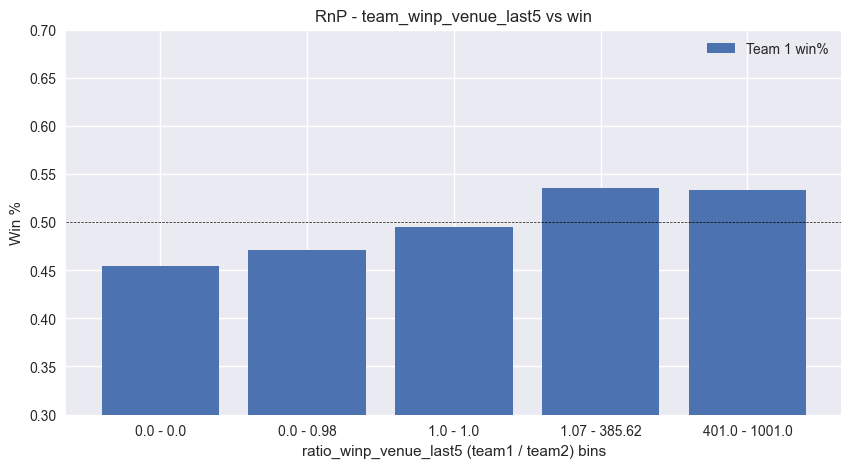

In [234]:
createRnP(train_data, 'team_winp_venue_last5')

In [235]:
# Compute team1 win% against team2 in their past 5 encounters for train data.
test_data['team1_winp_venue_last5'] = test_data.progress_apply(lambda x: \
                                  winpVenueLastn(x['team1_id'], x['ground_id'], x['match_dt'], 5), axis=1)
test_data['team2_winp_venue_last5'] = test_data.progress_apply(lambda x: \
                                  winpVenueLastn(x['team2_id'], x['ground_id'], x['match_dt'], 5), axis=1)
test_data['team_winp_venue_last5'] = (test_data['team1_winp_venue_last5']+0.1)/(test_data['team2_winp_venue_last5']+0.1)
test_data.drop(columns=['team1_winp_venue_last5', 'team2_winp_venue_last5'], inplace=True) # drop intermediate columns


100%|██████████| 207/207 [00:00<00:00, 461.86it/s]


#### Final view

In [236]:
train_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'winner_01', 'team_50_last20',
       'team_100_last20', 'team_30_last20', 'team_consistency_last20',
       'team1_winp_team2', 'team_bat_avg_last10',
       'team_bat_strike_rate_last10', 'toss_winner_01', 'light',
       'team_bowl_avg_last10', 'team_bowl_strike_rate_last10', 'team_eco',
       'team_bat_master', 'team_bowl_master', 'team_count_wickets_last20',
       'team_discipline_last20', 'pressure_index', 'team_winp_venue_last5'],
      dtype='object')

In [237]:
train_data['winner_01'] = train_data.apply(lambda x: 1 if (x['team1']==x['winner']) else 0, axis=1)

In [238]:
train_data.tail(2)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team_bat_avg_last10,team_bat_strike_rate_last10,toss_winner_01,light,team_bowl_avg_last10,team_bowl_strike_rate_last10,team_eco,team_bat_master,team_bowl_master,team_count_wickets_last20,team_discipline_last20,pressure_index,team_winp_venue_last5
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,0,0.931072,0.208609,0.644042,2.477651,66.667,1.046726,0.998040,1,2,0.828226,0.873834,0.948427,647.276896,511.650754,1.212017,0.317586,1,1001.000000
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,0,5.540733,11.427098,0.786688,2.306556,100.000,1.516910,1.182496,0,0,0.900912,0.949082,0.950066,515.095591,305.043951,1.624720,7.386688,0,0.001996


In [239]:
train_data.drop(columns=['team1', 'team1_roster_ids', 'team2', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'ground_avg_runs_last15', 'team1_winp_team2_last15'], inplace=True) # drop intermediate columns


In [240]:
train_data.tail()

,match id,team1_id,team2_id,winner_01,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team_bat_avg_last10,team_bat_strike_rate_last10,toss_winner_01,light,team_bowl_avg_last10,team_bowl_strike_rate_last10,team_eco,team_bat_master,team_bowl_master,team_count_wickets_last20,team_discipline_last20,pressure_index,team_winp_venue_last5
943,9128601,30407,30414,1,0.716993,0.994078,0.834298,0.429003,66.667,0.939940,1.023171,0,2,1.169902,1.155580,1.011819,415.640498,517.829713,0.547108,2.778804,1,0.375934
944,9433241,8700,9701,0,1.174605,0.499061,0.972037,0.267754,0.000,1.041707,0.930657,0,0,1.635702,1.243528,1.311604,267.252521,420.603474,0.536238,0.023731,0,0.001498
945,9097227,22497,23869,0,15.588444,1.000000,0.745531,1.000000,0.000,1.466595,1.060461,1,1,0.842814,0.872470,0.965563,549.582686,314.853785,0.613907,1.000000,0,1.000000
946,9516695,30428,36014,0,0.931072,0.208609,0.644042,2.477651,66.667,1.046726,0.998040,1,2,0.828226,0.873834,0.948427,647.276896,511.650754,1.212017,0.317586,1,1001.000000
947,9433633,7727,7608,0,5.540733,11.427098,0.786688,2.306556,100.000,1.516910,1.182496,0,0,0.900912,0.949082,0.950066,515.095591,305.043951,1.624720,7.386688,0,0.001996


In [241]:
test_data.tail()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team_bat_avg_last10,team_bat_strike_rate_last10,toss_winner_01,light,team_bowl_avg_last10,team_bowl_strike_rate_last10,team_eco,team_bat_master,team_bowl_master,team_count_wickets_last20,team_discipline_last20,pressure_index,team_winp_venue_last5
202,9984162,Pb Ks,30407,7881719.0:8127181.0:2231928.0:2642751.0:5053082.0:7923859.0:9660804.0:2035102.0:8180500.0:2733380.0:7453697.0:7881845.0,Ss Hd,36014,3710090.0:7491294.0:3127354.0:8228485.0:3057312.0:8117990.0:8228408.0:7925546.0:3429236.0:2282125.0:8072056.0:5618038.0,Pb Ks,bat,Rv Gi Il Sm Ul Hd,Hyderabad,2024-05-19,day/night match,In Pr Le,2024,13880,0.307692,1.952381,181.400000,50.0,181.625000,0.920069,0.709996,1.183850,1.383632,50.000,1.028915,0.936075,1,0,0.855915,0.852353,1.0,654.456942,544.064932,1.589629,1.589629,NaN,1.000000
203,9984176,Ss Hd,36014,3710090.0:7491294.0:3127354.0:8228485.0:8117990.0:3057312.0:8228408.0:7925546.0:3429236.0:2282125.0:8072056.0:5618038.0,Ka Kt Rs,30400,6818622.0:1613919.0:5959834.0:4497646.0:5061748.0:1934099.0:7556303.0:2181157.0:8465057.0:9188528.0:7758638.0,Ss Hd,bat,Na Mi Sm Ad,Ahmedabad,2024-05-21,night match,In Pr Le,2024,5893,0.857143,0.344262,189.133333,40.0,168.033333,0.759834,3.801089,0.850034,0.402225,33.333,0.991378,0.997024,1,2,1.528437,1.435151,1.0,415.439427,641.530907,0.437841,0.437841,NaN,0.001498
204,9984183,Rl Cs Bu,30393,1776627.0:313809.0:7537004.0:5765934.0:2275195.0:5972868.0:210328.0:1626057.0:212029.0:8118053.0:6586824.0:3456424.0,Rn Rs,30428,8058959.0:3294444.0:2981614.0:7556051.0:8228429.0:4690188.0:5742470.0:184960.0:1945397.0:4859490.0:3068547.0:3011735.0,Rn Rs,field,Na Mi Sm Ad,Ahmedabad,2024-05-22,night match,In Pr Le,2024,5893,1.368421,0.672131,185.666667,75.0,168.033333,1.593302,32.381080,0.714383,0.731102,75.000,1.252409,0.984784,0,2,1.258206,1.165071,1.0,758.430073,761.732594,0.582354,0.582354,NaN,1.000000
205,9984190,Ss Hd,36014,3710090.0:7491294.0:3127354.0:4203499.0:3057312.0:8228485.0:8228408.0:8117990.0:3429236.0:2733401.0:2282125.0:5618038.0,Rn Rs,30428,8058959.0:3294444.0:2981614.0:7556051.0:8228429.0:184960.0:4690188.0:5742470.0:1945397.0:3068547.0:4859490.0:3011735.0,Rn Rs,field,MA Cm Sm Ck Ci,Chennai,2024-05-24,night match,In Pr Le,2024,2050,0.736842,0.344262,189.133333,50.0,157.933333,0.545744,12.696446,0.557118,0.391854,50.000,0.961120,1.022988,0,2,1.019438,1.043229,1.0,581.351411,616.786892,0.753584,0.753584,NaN,251.000000
206,9984197,Ss Hd,36014,7491294.0:3710090.0:3127354.0:4203499.0:8228485.0:3057312.0:8117990.0:8228408.0:3429236.0:2733401.0:2282125.0:5618038.0,Ka Kt Rs,30400,6818622.0:1613919.0:5959834.0:4497646.0:5061748.0:1934099.0:7556303.0:2181157.0:8465057.0:9188528.0:7758638.0,Ss Hd,bat,MA Cm Sm Ck Ci,Chennai,2024-05-26,night match,In Pr Le,2024,2050,1.000000,0.344262,189.133333,40.0,157.933333,0.842240,4.085552,1.020373,0.402225,33.333,1.043039,0.987290,1,2,1.354032,1.300226,1.0,437.202886,568.110642,0.475779,0.475779,NaN,0.500998


In [242]:
test_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'toss winner', 'toss decision', 'venue',
       'city', 'match_dt', 'lighting', 'series_name', 'season', 'ground_id',
       'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'team_50_last20', 'team_100_last20',
       'team_30_last20', 'team_consistency_last20', 'team1_winp_team2',
       'team_bat_avg_last10', 'team_bat_strike_rate_last10', 'toss_winner_01',
       'light', 'team_bowl_avg_last10', 'team_bowl_strike_rate_last10',
       'team_eco', 'team_bat_master', 'team_bowl_master',
       'team_count_wickets_last20', 'team_discipline_last20', 'pressure_index',
       'team_winp_venue_last5'],
      dtype='object')

In [243]:
# test_data['toss_winner_01'] = test_data.apply(lambda x: 1 if (x['team1']==x['toss winner']) else 0, axis=1)

In [244]:
test_data.tail()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team_bat_avg_last10,team_bat_strike_rate_last10,toss_winner_01,light,team_bowl_avg_last10,team_bowl_strike_rate_last10,team_eco,team_bat_master,team_bowl_master,team_count_wickets_last20,team_discipline_last20,pressure_index,team_winp_venue_last5
202,9984162,Pb Ks,30407,7881719.0:8127181.0:2231928.0:2642751.0:5053082.0:7923859.0:9660804.0:2035102.0:8180500.0:2733380.0:7453697.0:7881845.0,Ss Hd,36014,3710090.0:7491294.0:3127354.0:8228485.0:3057312.0:8117990.0:8228408.0:7925546.0:3429236.0:2282125.0:8072056.0:5618038.0,Pb Ks,bat,Rv Gi Il Sm Ul Hd,Hyderabad,2024-05-19,day/night match,In Pr Le,2024,13880,0.307692,1.952381,181.400000,50.0,181.625000,0.920069,0.709996,1.183850,1.383632,50.000,1.028915,0.936075,1,0,0.855915,0.852353,1.0,654.456942,544.064932,1.589629,1.589629,NaN,1.000000
203,9984176,Ss Hd,36014,3710090.0:7491294.0:3127354.0:8228485.0:8117990.0:3057312.0:8228408.0:7925546.0:3429236.0:2282125.0:8072056.0:5618038.0,Ka Kt Rs,30400,6818622.0:1613919.0:5959834.0:4497646.0:5061748.0:1934099.0:7556303.0:2181157.0:8465057.0:9188528.0:7758638.0,Ss Hd,bat,Na Mi Sm Ad,Ahmedabad,2024-05-21,night match,In Pr Le,2024,5893,0.857143,0.344262,189.133333,40.0,168.033333,0.759834,3.801089,0.850034,0.402225,33.333,0.991378,0.997024,1,2,1.528437,1.435151,1.0,415.439427,641.530907,0.437841,0.437841,NaN,0.001498
204,9984183,Rl Cs Bu,30393,1776627.0:313809.0:7537004.0:5765934.0:2275195.0:5972868.0:210328.0:1626057.0:212029.0:8118053.0:6586824.0:3456424.0,Rn Rs,30428,8058959.0:3294444.0:2981614.0:7556051.0:8228429.0:4690188.0:5742470.0:184960.0:1945397.0:4859490.0:3068547.0:3011735.0,Rn Rs,field,Na Mi Sm Ad,Ahmedabad,2024-05-22,night match,In Pr Le,2024,5893,1.368421,0.672131,185.666667,75.0,168.033333,1.593302,32.381080,0.714383,0.731102,75.000,1.252409,0.984784,0,2,1.258206,1.165071,1.0,758.430073,761.732594,0.582354,0.582354,NaN,1.000000
205,9984190,Ss Hd,36014,3710090.0:7491294.0:3127354.0:4203499.0:3057312.0:8228485.0:8228408.0:8117990.0:3429236.0:2733401.0:2282125.0:5618038.0,Rn Rs,30428,8058959.0:3294444.0:2981614.0:7556051.0:8228429.0:184960.0:4690188.0:5742470.0:1945397.0:3068547.0:4859490.0:3011735.0,Rn Rs,field,MA Cm Sm Ck Ci,Chennai,2024-05-24,night match,In Pr Le,2024,2050,0.736842,0.344262,189.133333,50.0,157.933333,0.545744,12.696446,0.557118,0.391854,50.000,0.961120,1.022988,0,2,1.019438,1.043229,1.0,581.351411,616.786892,0.753584,0.753584,NaN,251.000000
206,9984197,Ss Hd,36014,7491294.0:3710090.0:3127354.0:4203499.0:8228485.0:3057312.0:8117990.0:8228408.0:3429236.0:2733401.0:2282125.0:5618038.0,Ka Kt Rs,30400,6818622.0:1613919.0:5959834.0:4497646.0:5061748.0:1934099.0:7556303.0:2181157.0:8465057.0:9188528.0:7758638.0,Ss Hd,bat,MA Cm Sm Ck Ci,Chennai,2024-05-26,night match,In Pr Le,2024,2050,1.000000,0.344262,189.133333,40.0,157.933333,0.842240,4.085552,1.020373,0.402225,33.333,1.043039,0.987290,1,2,1.354032,1.300226,1.0,437.202886,568.110642,0.475779,0.475779,NaN,0.500998


In [245]:
test_data['pressure_index'].isna()

0      True
1      True
2      True
3      True
4      True
       ... 
202    True
203    True
204    True
205    True
206    True
Name: pressure_index, Length: 207, dtype: bool

In [246]:
train_data.drop(columns=['pressure_index'], inplace = True)

In [247]:
test_data.drop(columns=['team1', 'team1_roster_ids', 'team2', 'team2_roster_ids', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'ground_avg_runs_last15', 'team1_winp_team2_last15', 'pressure_index'], inplace=True) # drop intermediate columns


In [248]:
test_data.tail()

,match id,team1_id,team2_id,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team_bat_avg_last10,team_bat_strike_rate_last10,toss_winner_01,light,team_bowl_avg_last10,team_bowl_strike_rate_last10,team_eco,team_bat_master,team_bowl_master,team_count_wickets_last20,team_discipline_last20,team_winp_venue_last5
202,9984162,30407,36014,0.920069,0.709996,1.183850,1.383632,50.000,1.028915,0.936075,1,0,0.855915,0.852353,1.0,654.456942,544.064932,1.589629,1.589629,1.000000
203,9984176,36014,30400,0.759834,3.801089,0.850034,0.402225,33.333,0.991378,0.997024,1,2,1.528437,1.435151,1.0,415.439427,641.530907,0.437841,0.437841,0.001498
204,9984183,30393,30428,1.593302,32.381080,0.714383,0.731102,75.000,1.252409,0.984784,0,2,1.258206,1.165071,1.0,758.430073,761.732594,0.582354,0.582354,1.000000
205,9984190,36014,30428,0.545744,12.696446,0.557118,0.391854,50.000,0.961120,1.022988,0,2,1.019438,1.043229,1.0,581.351411,616.786892,0.753584,0.753584,251.000000
206,9984197,36014,30400,0.842240,4.085552,1.020373,0.402225,33.333,1.043039,0.987290,1,2,1.354032,1.300226,1.0,437.202886,568.110642,0.475779,0.475779,0.500998


In [249]:
train_data.tail()

,match id,team1_id,team2_id,winner_01,team_50_last20,team_100_last20,team_30_last20,team_consistency_last20,team1_winp_team2,team_bat_avg_last10,team_bat_strike_rate_last10,toss_winner_01,light,team_bowl_avg_last10,team_bowl_strike_rate_last10,team_eco,team_bat_master,team_bowl_master,team_count_wickets_last20,team_discipline_last20,team_winp_venue_last5
943,9128601,30407,30414,1,0.716993,0.994078,0.834298,0.429003,66.667,0.939940,1.023171,0,2,1.169902,1.155580,1.011819,415.640498,517.829713,0.547108,2.778804,0.375934
944,9433241,8700,9701,0,1.174605,0.499061,0.972037,0.267754,0.000,1.041707,0.930657,0,0,1.635702,1.243528,1.311604,267.252521,420.603474,0.536238,0.023731,0.001498
945,9097227,22497,23869,0,15.588444,1.000000,0.745531,1.000000,0.000,1.466595,1.060461,1,1,0.842814,0.872470,0.965563,549.582686,314.853785,0.613907,1.000000,1.000000
946,9516695,30428,36014,0,0.931072,0.208609,0.644042,2.477651,66.667,1.046726,0.998040,1,2,0.828226,0.873834,0.948427,647.276896,511.650754,1.212017,0.317586,1001.000000
947,9433633,7727,7608,0,5.540733,11.427098,0.786688,2.306556,100.000,1.516910,1.182496,0,0,0.900912,0.949082,0.950066,515.095591,305.043951,1.624720,7.386688,0.001996


# Save

In [250]:
train_data.to_csv('train_data_processed69_2.csv', index=False)
test_data.to_csv('R2_data_processed_69_2.csv', index=False)